In [1]:
import scvelo as scv
import scanpy as spy
import numpy as np  
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger

import seaborn as sns

matplotlib_axes_logger.setLevel('ERROR')
import json
import anndata


import multraj.visual as visual
import multraj.clustering as clust
import multraj.pp as pp
import multraj.path as path
import multraj.nn as nn
import multraj.princurve as pcurve
import multraj.benchmark as bmk


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.kernel_ridge import KernelRidge

# Meta-cell construction

In [2]:
# read in simulated dataset
# adata = anndata.read_h5ad("./sim_data/Symsim/cycle_tree_rand1.h5ad")
adata = anndata.read_h5ad("./sim_data/Symsim/cycle_tree_rand2.h5ad")

# adata = anndata.read_h5ad("./sim_data/Symsim/cycle_tree_rand1_clust.h5ad")

In [3]:
# number of clusters
clusters = 400 # 500
# number of trials
n_trials = 10
# cluster obj

clust.cluster_cells(adata, n_clusters = clusters, n_init = n_trials)

X_cluster, velo_cluster = clust.meta_cells(adata)
# number of clusters
groups = adata.obs['groups']

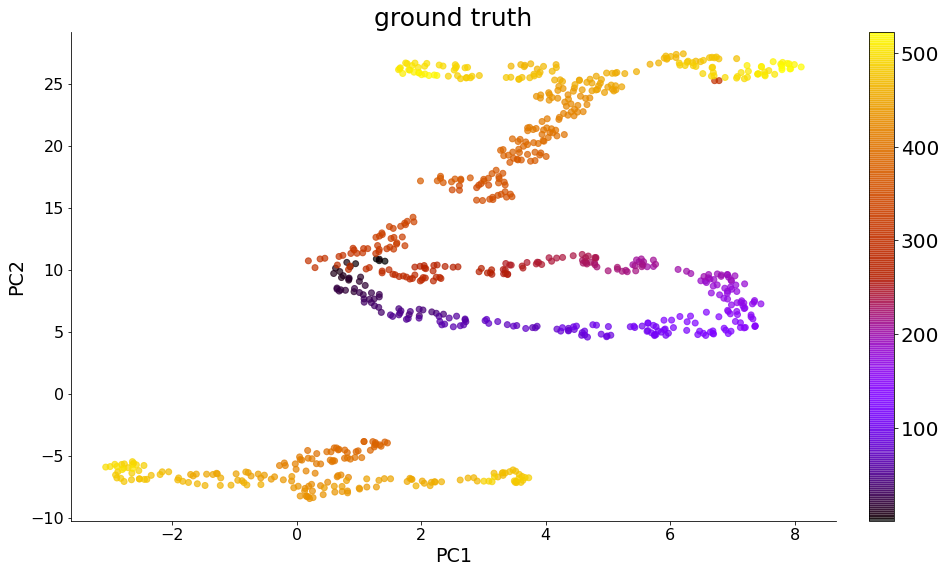

In [4]:
X_pca = adata.obsm['X_umap']
fig = plt.figure(figsize = (15,9))
ax = fig.add_subplot()
pic = ax.scatter(X_pca[:,0],X_pca[:,1], alpha = 0.7, cmap = 'gnuplot', c = adata.obs['sim_time'].values)
ax.tick_params(axis = "both", direction = "out", labelsize = 16)
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("ground truth", fontsize = 25)

cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)
# fig.savefig("./sim_results/Symsim/cycle_tree/rand1/ground_truth.pdf", bbox_inches = 'tight')

The clusters with radius close to 0 has components number:
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

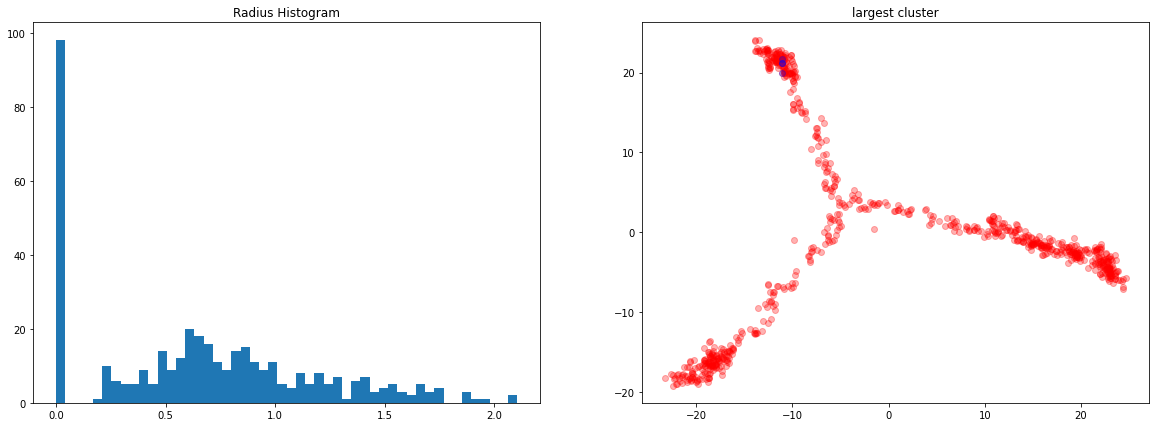

In [5]:
max_group = visual.radius_hist(adata, scaling=50)

# Neighborhood graph construction

make symmetric by adding


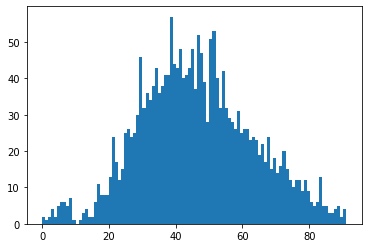

In [6]:
k = 10 #10
adj_matrix,dist_matrix = nn.NeighborhoodGraph(X_cluster,k, symm = True, pruning=False)
adj_assigned, max_weight = nn.assign_weights(adj_matrix,dist_matrix, X_cluster, velo_cluster,scaling = 3,\
                              distance_scaler = 0.5,thresholding = 0.0)
visual.weight_histogram(adj_assigned, scaling=100,upper=max_weight)

# Meta-cell level paths inference

In [7]:
paths, opt = path.dijkstra_paths(adj_assigned, indeg = [0,1,2])
clusters = int(np.max(groups)+1)
greedy_paths, paths = path.greedy_selection(clusters, paths, opt, threshold = 0.5, max_w=max_weight, cut_off=5, verbose=True, length_bias=0.7, max_trajs = 15)

cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  307_327 , len:  51 newly covered: 50
start_end:  307_13 , len:  48 newly covered: 15
start_end:  307_177 , len:  51 newly covered: 8
start_end:  307_93 , len:  50 newly covered: 5
start_end:  307_58 , len:  47 newly covered: 7
start_end:  11_272 , len:  31 newly covered: 17
start_end:  307_284 , len:  48 newly covered: 5
start_end:  307_134 , len:  45 newly covered: 7
start_end:  307_293 , len:  50 newly covered: 3
start_end:  307_38 , len:  50 newly covered: 2
start_end:  307_23 , len:  44 newly covered: 6
start_end:  307_186 , len:  51 newly covered: 1
start_end:  307_346 , len:  51 newly covered: 1
start_end:  307_387 , len:  49 newly covered: 2
start_end:  307_51 , len:  49 newly covered: 2
Finished


In [8]:
trajs = 4

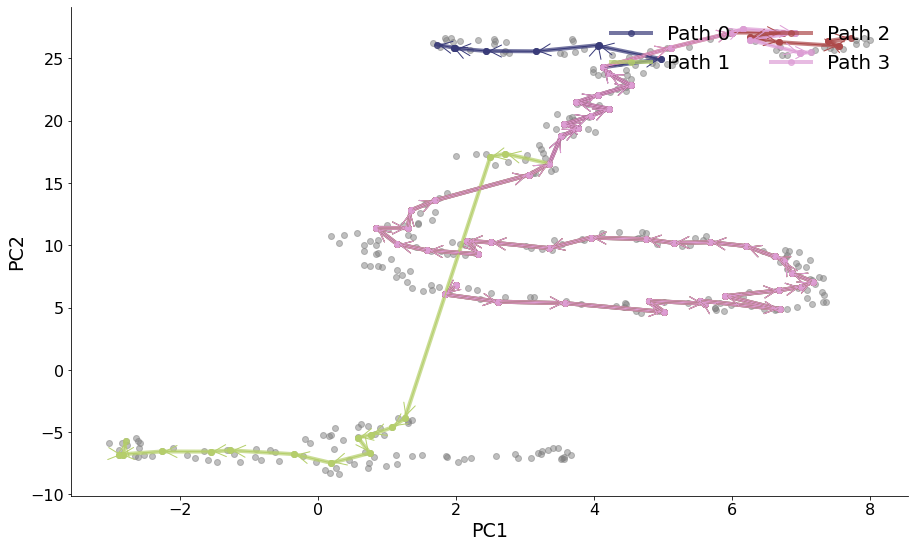

In [9]:
X_umap = adata.obsm['X_umap']
X_umap_cluster = np.zeros((clusters,2))
for c in range(clusters):
    indices = np.where(groups == c)[0]
    X_umap_cluster[c,:] = np.mean(X_umap[indices,:],axis=0)
# trajs = 8
visual.meta_traj_visual(X_umap_cluster, paths, greedy_paths, trajs = trajs, figsize = (15,9), save_as = None)#"./sim_results/Symsim/cycle_tree/rand1/clust_paths.pdf")

# Cell-level pseudo-time inference
## first order approximation 

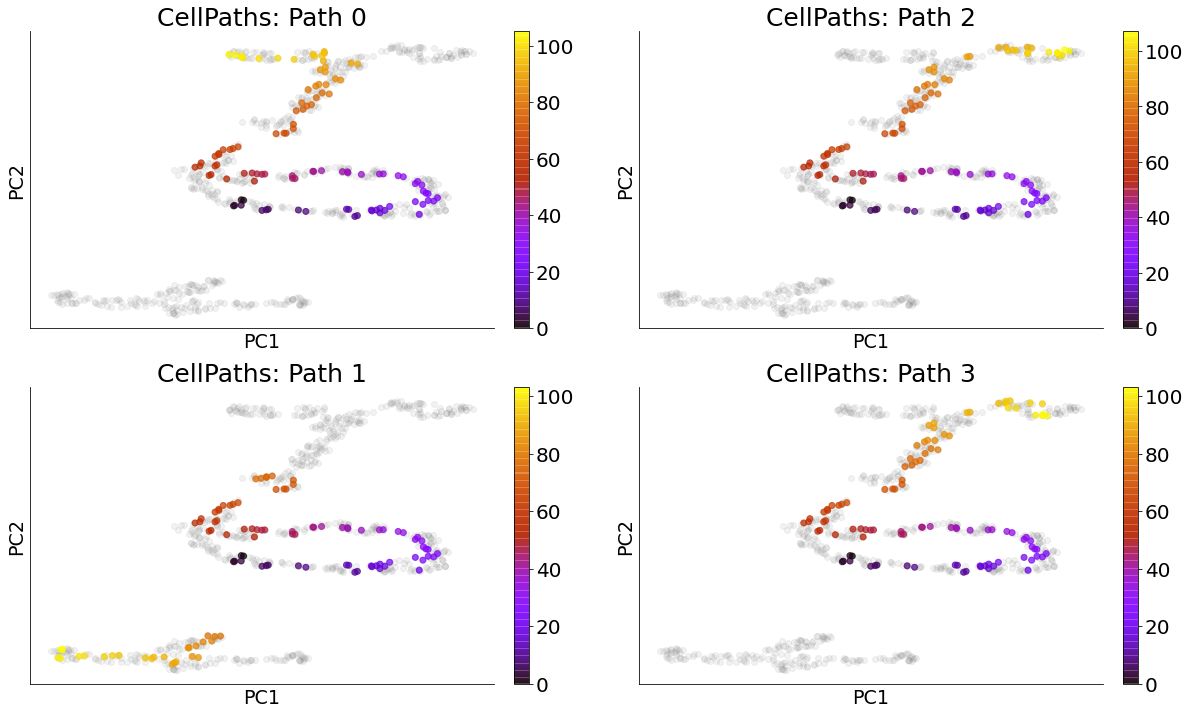

In [10]:
pseudo_order = visual.first_order_approx_pt(adata, paths, greedy_paths, X_cluster, velo_cluster, basis = 'umap', groups = None, trajs = 4, figsize= (20,12), save_as = None) # "./sim_results/Symsim/cycle_tree/rand1/first_order_pt.pdf")

In [11]:
non_zeros = {}
pt_pred = {}
pt_true = {}
kt = {}
for icol, col in enumerate(pseudo_order.columns):
    non_zeros[col] = np.where(~np.isnan(pseudo_order[col].values.squeeze()))[0]
    pt_pred[col] = pseudo_order.iloc[non_zeros[col], icol].values.squeeze()
    pt_true[col] = adata.obs["sim_time"].iloc[non_zeros[col]].values
    kt[col] = bmk.kendalltau(pt_pred[col], pt_true[col])

# velocity DPT

In [12]:
adata = anndata.read_h5ad("./sim_data/Symsim/cycle_tree_rand2.h5ad")
scv.tl.velocity_pseudotime(adata)

computing terminal states
    identified 1 region of root cells and 2 regions of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [13]:
y_vdpt = adata.obs['velocity_pseudotime'].values
vdpt_pred  = {}
kt_vdpt = {}
for icol, col in enumerate(pseudo_order.columns):
    non_zeros[col] = np.where(~np.isnan(pseudo_order[col].values.squeeze()))[0]
    vdpt_pred[col] = y_vdpt[non_zeros[col]]
    kt_vdpt[col] = bmk.kendalltau(vdpt_pred[col], pt_true[col])

In [14]:
kt_vdpt

{'traj_0': 0.7448337825696317,
 'traj_1': 0.720687079910381,
 'traj_2': 0.7358947732779507,
 'traj_3': 0.7384931411141431}

## Slingshot

In [15]:
from sklearn.cluster import KMeans

In [16]:
# adata = anndata.read_h5ad("./sim_data/Symsim/cycle_tree_rand1_clust.h5ad")
X_pca = adata.obsm['X_umap']

In [17]:
n_clusters = 10
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)
meta_data = adata.obs
meta_data['groups'] = groups

Text(0.5, 1.0, 'slingshot clusters')

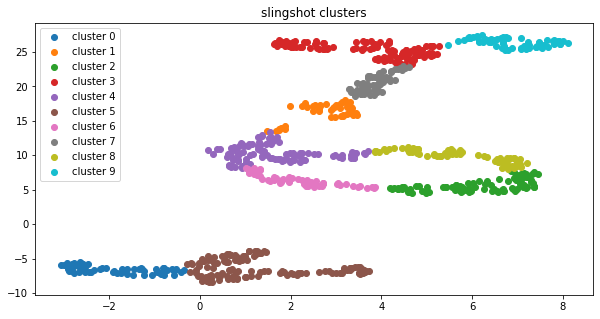

In [18]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()
c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))
    # progression = ax.scatter(X_umap[sub_cells,0], X_umap[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")
# fig.savefig("./syn_results/dataset1/slingshot_clust.pdf")

In [19]:
import scprep
import pandas as pd

In [20]:
X_pca_df = pd.DataFrame(index=[str(x) for x in range(X_pca.shape[0])], columns= np.arange(2), data = X_pca[:,0:2])
# scprep.run.install_bioconductor('slingshot')
results = scprep.run.Slingshot(X_pca_df, meta_data['groups'], start_cluster = 6)

R[write to console]: Using full covariance matrix


In [21]:
def slingshot_visual(adata, results, basis = "umap", trajs = None, show_pcurve = True, figsize = (20,10), save_as = None):
    X_pca = adata.obsm['X_' + basis]
    label = adata.obs['sim_time'].values
    if trajs == None:
        trajs = results['pseudotime'].shape[1]
    nrows = np.ceil(trajs).astype('int32')
    ncols = 1
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)

    kt = {}

    # fig.suptitle("slingshot pseudo-time", fontsize = 18)
    for i in range(trajs):
        if nrows == 1 or ncols == 1:
            if nrows == 1 and ncols == 1:
                ax = axs
            else:
                ax = axs[i]
        else:
            ax = axs[i%nrows, i//nrows]
        ax.scatter(X_pca[:,0],X_pca[:,1], color = 'gray', alpha = 0.1)

        if show_pcurve:
            # for curve in results['curves']:
            ax.plot(results['curves'][i,:,0],results['curves'][i,:,1],color = 'black')

        pt_i = results['pseudotime'].iloc[:,i]
        # eliminate `cell` in the string

        pt_index = [x for x in pt_i.index if not np.isnan(pt_i[x])]
        ordering = [eval(x) for x in pt_i[pt_index].sort_values().index]

        pt_i = pt_i[pt_index]
        true_i = adata.obs['sim_time'].iloc[pt_index].values

        # pred = np.array([np.nanmean(x) for x in results["pseudotime"].values])
        # vx = pred - np.mean(pred)
        # vy = label - np.mean(label)
        # pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))

        kt["traj_"+str(i)] = bmk.kendalltau(pt_i, true_i)
        X_traj = X_pca[ordering,:]

        pseudo_visual = ax.scatter(X_traj[:,0],X_traj[:,1],c = np.arange(X_traj.shape[0]), cmap=plt.get_cmap('gnuplot'),alpha = 0.7)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("PC1", fontsize = 19)
        ax.set_ylabel("PC2", fontsize = 19)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        cbar = fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax)
        cbar.ax.tick_params(labelsize = 20)
        
        ax.set_title("Slingshot: Path " + str(i), fontsize = 25)
        # fig.suptitle("Pearson correlationship: "+ str(pearson))
    if save_as != None:
        fig.savefig(save_as,bbox_inches = 'tight')
    plt.show()    
    return kt

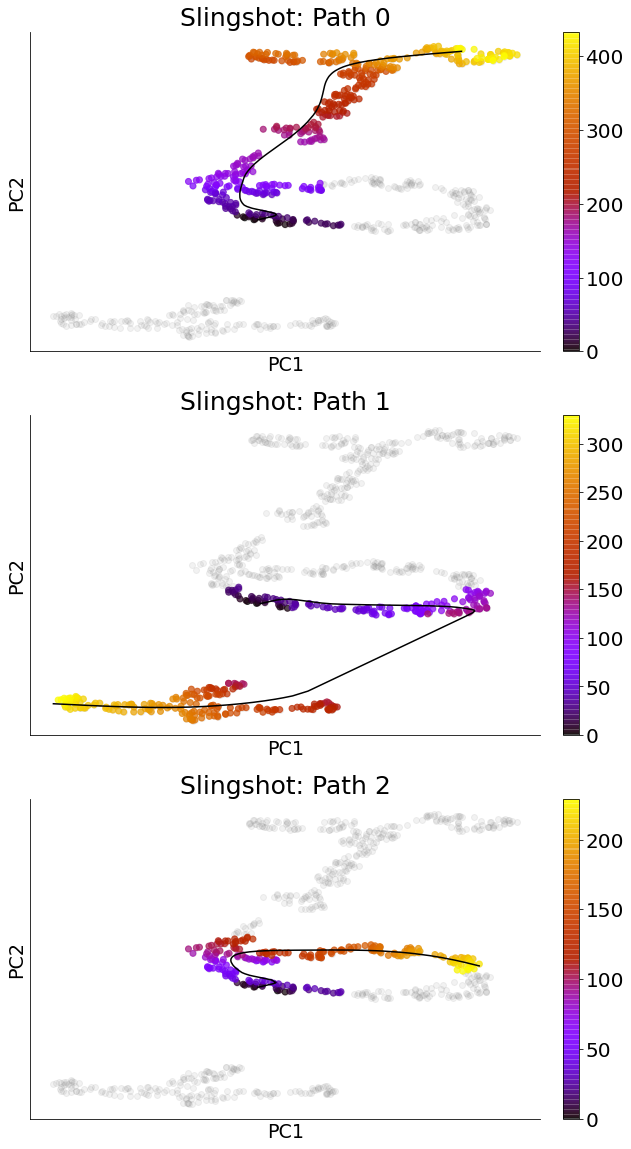

In [22]:
kt_slingshot = slingshot_visual(adata, results, figsize=(10,20), save_as = None)

In [26]:
kts = {"CellPaths": kt, "slingshot": kt_slingshot, "vdpt": kt_vdpt}
with open("./sim_results/Symsim/cycle_tree/quantity/rand2.json", "w") as fp:
    json.dump(kts, fp)

In [30]:
with open("./sim_results/Symsim/cycle_tree/quantity/rand1.json", "r") as fp:
    kts_1 = json.load(fp)
with open("./sim_results/Symsim/cycle_tree/quantity/rand2.json", "r") as fp:
    kts_2 = json.load(fp)

In [35]:
kts["CellPaths"] = [x for x in kts_1["CellPaths"].values()]
kts["CellPaths"].extend([x for x in kts_2["CellPaths"].values()])

kts["slingshot"] = [x for x in kts_1["slingshot"].values()]
kts["slingshot"].extend([x for x in kts_2["slingshot"].values()])

kts["vdpt"] = [x for x in kts_1["vdpt"].values()]
kts["vdpt"].extend([x for x in kts_2["vdpt"].values()])


In [40]:
kts_array = [kts["CellPaths"], kts["slingshot"], kts["vdpt"]]

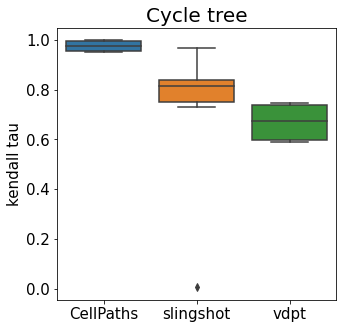

In [74]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
sns.boxplot(data = kts_array, ax = ax)#, x = ["CellPaths", "slingshot", "vdpt"])
ax.set_xticklabels(["CellPaths", "slingshot", "vdpt"],fontsize = 15)
ax.set_ylabel("kendall tau", fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_title("Cycle tree", fontsize = 20)
fig.savefig("./sim_results/Symsim/cycle_tree/quantity/boxplot.pdf", bbox_inches = "tight")

# Benchmark

In [14]:
bmk_belongings = bmk.purity_count(adata, paths, greedy_paths, trajs = trajs)
bmk_belongings      

,ori_traj_1,ori_traj_2,ori_traj_3,ori_traj_4,ori_traj_5
reconst_1,50,39,44,88,42
reconst_2,49,25,71,23,29
reconst_3,26,43,27,30,63
reconst_4,55,35,44,95,42
reconst_5,52,36,44,93,42
reconst_6,50,39,44,90,42


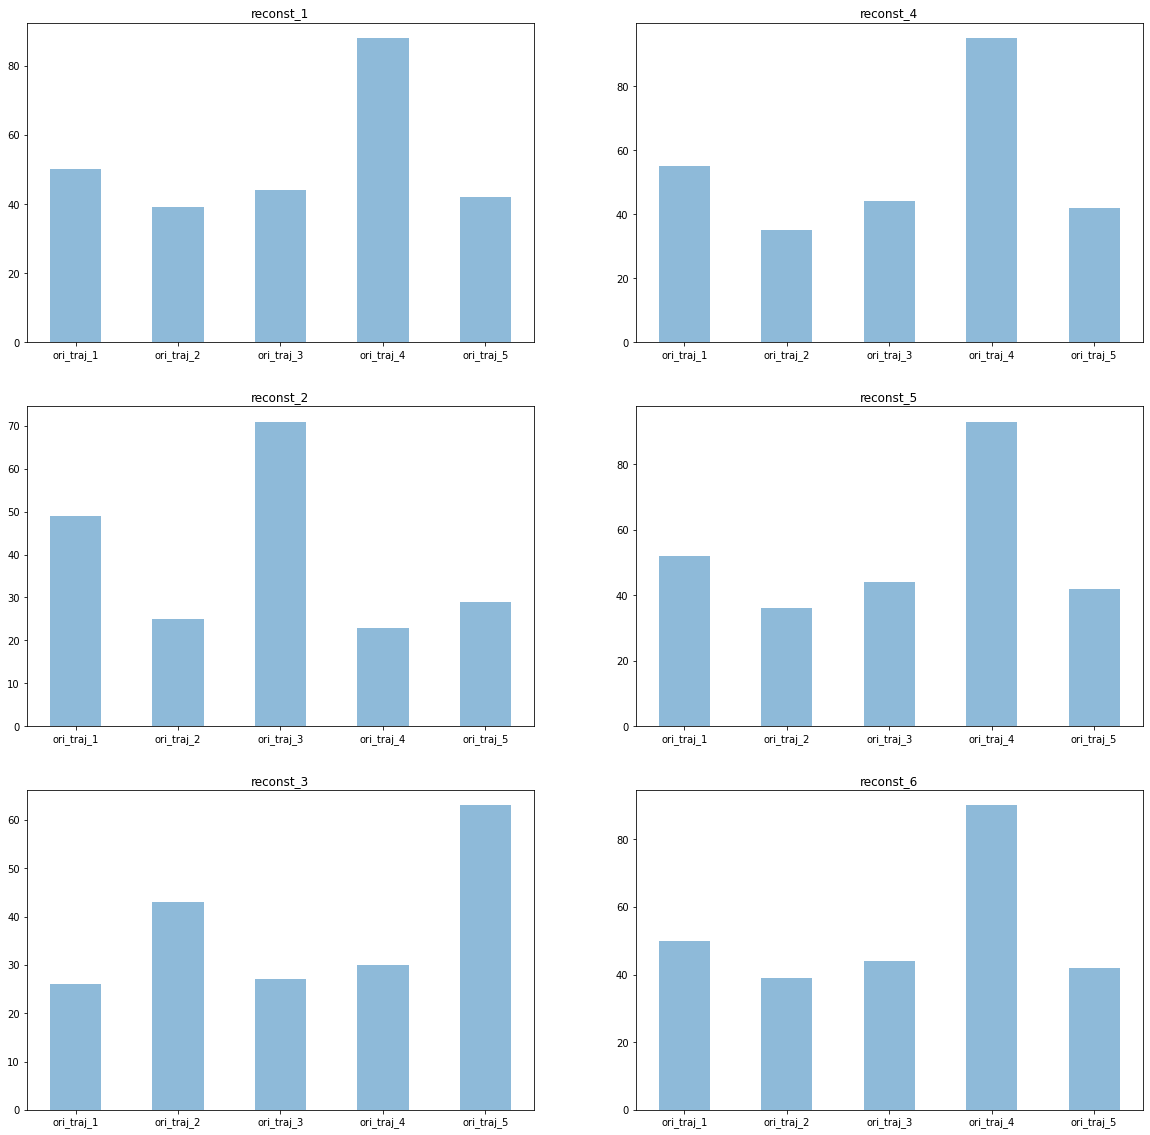

In [15]:
visual.purity_bar(bmk_belongings, trajs = trajs)